# Ontario's Sunshine List (1996-2020)

Project Group 2:

- William Conley - 100782574
- Reese Dominguez - 100775764
- Alex Sawatzky - 100790274
- Joshua Trower - 100791683

## Introduction

### The Ontario Public Sector Safety Disclosure/Sunshine List

The [Ontario Public Sector Safety Disclosure](https://www.ontario.ca/page/public-sector-salary-disclosure#section-1), henceforth referred to as the **Sunshine List** for this notebook, started its collection in 1996 as a result of the **Public Sector Salary Disclosure Act** passed by the Government of Ontario. This act requires public service organizations to submit staff and salary information for all staff that earn more than \$100,000 during a calendar year by March of the year after, so as to make this data available to the public and to make public service organizations accountable for the use of the province's funding.

Although this is a positive step when it comes to transparency in the government level, the data does not show basic demographics such as gender and race, especially after the passing of the [Anti-Racism Act in 2017](https://news.ontario.ca/en/release/44976/ontario-passes-anti-racism-legislation). We want to explore any discrepancies in equity in gender and race regarding the public sector's highest paid employees.

We start by answering these basic questions, and then answering any other questions that appear as a result:

1. Which sector has the most people/largest budget?
2. What proportion of Sunshine Listers are women?
3. What proportion of Sunshine Listers are racialized?
4. How much of a change has there been since 1996?
5. Are any sectors improving in their racial/gender representation?

## Description of Data

As the Sunshine List has already been described in the introduction, we take this opportunity to introduce our auxiliary/helper datasets. Note that this has been taken almost verbatim from the descriptions in our proposal:

#### World Gender Name Dictionary
Link: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/MSEGSJ 

Citation: Raffo, Julio, 2021, "WGND 2.0", https://doi.org/10.7910/DVN/MSEGSJ, Harvard Dataverse, V1, UNF:6:5rI3h1mXzd6zkVhHurelLw== [fileUNF]

This data set is available on Harvard’s dataverse which is an archive of data that has been used in research and is made available for use by other researchers.  The data was compiled by Martinez, Lax, Raffo and Saito in 2016 as part of their research paper “Identifying the Gender of PCT Inventors.”  The author has compiled more than 26 million records and linked the given names from over 195 different countries and territories. Similar to the work of Raffo, this dataset will be used to explore the representation of women on the Sunshine List.  It is important to note that using a database of names to assign genders is an imprecise approach and in many cases may misattribute gender given how many names there are that are used by both genders (like Chris or Sam). However, since the sunshine list does not include gender in the datasets, it is hoped that this imprecise approach may still offer some value in the consideration of gender representation on the Sunshine list. This data has been made available as CCO – “Public Domain Dedication”.

#### Most Common Names Database
Link: https://raw.githubusercontent.com/fivethirtyeight/data/master/most-common-name/surnames.csv 

This data set is available on FiveThirtyEight's [Github (direct link)](https://github.com/fivethirtyeight/data/blob/master/most-common-name/). [FiveThirtyEight](https://fivethirtyeight.com/)  is a website devoted to using statistics to understand political, social and sporting trends.  The data is maintained by Andrew Flowers as part of the article “Dear Mona, What’s The Most Common Name in America?” article.  This data is a compilation of surnames from the US Census Bureau which includes the percentage of the population that identifies as White, Black, Asian, Hispanic and Multiple Races. It is important to note that determining racial identity solely by surname is an imprecise approach, given that each surname often has representation across all racial identities.  However, since the sunshine list does not include employee racial identity, it is hoped that this imprecise approach may still offer some value in consideration of the representative diversity on the Sunshine List.  This data has been made available under a Creative Commons Attribution 4.0 International License.

#### Ontario Demographics
Link: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/prof/details/Page.cfm?Lang=E&Geo1=PR&Code1=35&Geo2=&Code2=&Data=Count&SearchText=Ontario&Sear

This dataset is maintained by Statistics Canada and provides provincial and national statistics on population demographics.  This will serve as a baseline to compare proportions and see if a group is over or under represented. The latest census publically available is that for 2016, as 2021's will be available in February 2022.

## Analysis of Data

We first import all the datasets we intend to use. For the Sunshine List, since we're working with 24 years' worth of work, we concatenate them all into one dataframe.

In [1]:
#importing used libraries
import csv
import re
import pandas as pd
from functools import reduce
import numpy as np
import calendar
import string
import matplotlib.pyplot as plt
import random

# seaborn
import seaborn as sns

In [2]:
# dataset import preparation
data_path = 'datasets/'
# reads CSV file, returns data in Python dict
# thanks Mariana ^^;

# to anyone else working on this: modify as needed.
def get_data_csv(path):
    collection = []
    with open(path, 'r') as f:
        for line in csv.DictReader(f):
            collection.append(line)
        return collection

In [3]:
# dataset importing - sunshine lists

# because the "Salary Paid" column is formatted 
# differently for each list...
def format_sunshine(path):
    return (pd.DataFrame(get_data_csv(path))).rename(columns = {"Salary paid" : "Salary Paid",
                                                                "Salary Paid " : "Salary Paid",
                                                                "Surname": "Last Name",
                                                                "Last name": "Last Name",
                                                                "Position": "Job Title",
                                                                "Job title": "Job Title",
                                                                "Calendar year": "Calendar Year",
                                                                "First name": "First Name",
                                                                "Taxable benefits": "Taxable Benefits"})

# concatenating all into one df
df_sunshine = format_sunshine(data_path + 'sunshine1996.csv')
df_sunshine["Calendar Year"] = 1996

for yr in range(1997, 2021):
    # calling it a temp dataset because it'll be rewritten
    # w/ each loop
    curr_file = data_path + 'sunshine' + str(yr) + '.csv'
    df_temp = format_sunshine(curr_file)
    df_temp["Calendar Year"] = yr
    df_sunshine = pd.concat([df_sunshine, df_temp], ignore_index=True)

In [4]:
df_sunshine.drop(columns=[''], inplace=True)
# More fixing up formatting: 

# putting salary paid/taxable benefits into usable format
# taxable benefits commented as i don't know if we'll use it
# df_sunshine["Taxable Benefits"] = df_sunshine["Taxable Benefits"].replace('[\$,]', '', regex=True).astype(float)
df_sunshine["Salary Paid"] = df_sunshine["Salary Paid"].replace('[\$,]', '', regex=True).astype(float)

# changing all names/sectors to title case
df_sunshine["Sector"] = df_sunshine["Sector"].str.title()
df_sunshine["Last Name"] = df_sunshine["Last Name"].str.title()
df_sunshine["First Name"] = df_sunshine["First Name"].str.title()

Although the salary data is provided by the Ontario government, there were several quality issues that had to be dealt with before a meaningful analysis coul dbe conducted.  These issues included inconsistent naming conventions (i.e. names that varied between "and", "&" or "-" from one year to the next), and errors in data entry in the provincial files (i.e. the decimal on one person's salary was entered as a comma which skewed the overall distributions). In the instance of the incorrect decimal place, the value in the datafile was corrected manually.

In [38]:
# More formatting for the sectors
replacements = {
    'Sector': {
        r'\\xa0': ' ',
        r'\*': '',
        r'\&': 'And',
        r'(\:|—|–)': '-',
        r'(Comm)(\.|unity)\sSafety\s?(&|And|\/)\s?(Corr)(\.|ectional)(\s|\\xa0)?(S(e?)rv(i?)c(e?)s(\.?))': 'Community Safety And Correctional Services',
        r'^\s+': '',
        r'\s+$': '',
        r' - Universités': '',
        r' And Offices': '',
        r' Employers': '',
        r'Health Promotion And Sport': 'Health Promotion',
        r' And Infrastructure': '',
        r'\sAnd\s[a-zA-Z]+(\s[a-zA-Z]+)*': '',
    }
}

df_sunshine.replace(replacements, regex=True, inplace=True)

# The Sunshine List

## Description of data attributes

This dataset contains all public sector employees who have been paid $100,000 or more for the calendar year.

- **Sector:** The government-controlled field that the employee works in
- **Last name:** The employee's last name
- **First name:** The employee's first name
- **Salary paid:** The amount of money the employee made in the calendar year
- **Taxable benefits:** Benefits added to the employee's income to determine tax deductions
- **Employer:** The organization/person the employee works in
- **Job title:** The employee's job or position
- **Calendar year:** The year this data was recorded in

A sample of the dataset is shown below.

In [5]:
# there may be more fixing to be done, but this is okay for now
df_sunshine

,Sector,Last Name,First Name,Salary Paid,Taxable Benefits,Employer,Job Title,Calendar Year
0,Other Public Sector Employers,Kendall,Perry,194890.40,$711.24,Addiction Research Foundation,President & CEO,1996
1,Other Public Sector Employers,Rehm,Juergen,115603.62,$403.41,Addiction Research Foundation,"Dir., Soc. Eval. Research & Act. Dir., Clin. R...",1996
2,Other Public Sector Employers,Room,Robin,149434.48,$512.58,Addiction Research Foundation,"V.P., Research & Coordinator, Intern. Programs",1996
3,Ontario Public Service,Knox,Ken W,109382.92,"$4,921.68","Agriculture,Food and Rural Affairs",Deputy Minister,1996
4,Hospitals,Cliff,Bruce,110309.00,"$3,157.00",Ajax and Pickering General Hospital,President & CEO,1996
...,...,...,...,...,...,...,...,...
1676428,Universities,Zylberberg,Joel,141478.88,$727.20,York University,Assistant Professor / Canada Research Chair,2020
1676429,Universities,Zylla,Phil,127898.47,$231.93,McMaster Divinity College,Vice President Academic,2020
1676430,Universities,Zytaruk,Nicole,113582.77,$231.93,McMaster University,Research Associate,2020
1676431,Universities,Zytner,Richard,193168.37,"$1,906.08",University Of Guelph,Professor,2020


In [6]:
# importing the WGND
df_wgnd = pd.DataFrame(get_data_csv(data_path + 'wgnd.csv'))

# The World Gender Names Database

## Description of data attributes

This dataset contains all possible first names (in Latin characters), and the likelihood that a person with that name is that gender.

- **name:** A capitalized first name
- **gender:** The more likely gender the name is to be
- **probability:** The probability of the more likely gender

A sample of the dataset is shown below.

In [7]:
df_wgnd

,name,gender,probability
0,Aaban,M,1
1,Aabha,F,1
2,Aabid,M,1
3,Aabriella,F,1
4,Aada,F,1
...,...,...,...
95021,Zyvon,M,1
95022,Zyyanna,F,1
95023,Zyyon,M,1
95024,Zzyzx,M,1


In [8]:
# importing the MCND
df_mcnd = pd.DataFrame(get_data_csv(data_path + 'surnames.csv'))

# The Most Common Names Database

From FiveThirtyEight: "Data on surnames from the U.S. Census Bureau, including a breakdown by race/ethnicity."

## Description of data attributes

- **name:** A capitalized surname
- **rank:** The rank, based on `count`, of the surname
- **count:** The number of people in the US who have this surname
- **prop100k:** In a sample of 100,000 people, how many people are likely to have this surname?
- **cum_prop100k:** A sum of the surname's `prop100k` value with the values of those higher in rank 
- **pctwhite:** Percentage of white people with this surname
- **pctblack:** Percentage of black people with this surname
- **pctapi:** Percentage of Asian/Pacific Islander people with this surname
- **pctaian:** Percentage of Native American people with this surname
- **pct2prace:** Percentage of mixed-race people with this surname
- **pcthispanic:** Percentage of Hispanic people with this surname

A sample of the dataset is shown below.

In [9]:
df_mcnd.name = df_mcnd.name.str.title()

df_mcnd

,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic
0,Smith,1,2376206,880.85,880.85,73.35,22.22,0.4,0.85,1.63,1.56
1,Johnson,2,1857160,688.44,1569.3,61.55,33.8,0.42,0.91,1.82,1.5
2,Williams,3,1534042,568.66,2137.96,48.52,46.72,0.37,0.78,2.01,1.6
3,Brown,4,1380145,511.62,2649.58,60.71,34.54,0.41,0.83,1.86,1.64
4,Jones,5,1362755,505.17,3154.75,57.69,37.73,0.35,0.94,1.85,1.44
...,...,...,...,...,...,...,...,...,...,...,...
151666,Yousko,150436,100,0.04,89752.93,99,(S),0,0,0,(S)
151667,Zaitsev,150436,100,0.04,89753.04,92,(S),0,0,7,(S)
151668,Zalla,150436,100,0.04,89753.11,99,(S),0,0,0,(S)
151669,Zerbey,150436,100,0.04,89753.3,99,(S),0,0,0,(S)


In [10]:
# importing the Ontario census
df_census = pd.read_csv(data_path + 'census2016.csv')
df_census.drop(df_census.index[range(2249,2782)],  inplace=True) # there are 600 lines worth of notes alone.
df_census.reset_index(inplace=True)
df_census.fillna('-',inplace=True)

# The Census

A dataset that contains a lot of data about the demographics of Canadian residents, more specifically, in this case, residents of Ontario.

## Description of data attributes

There are too many fields to take into account, so we list the topics:

In [11]:
df_census.level_0.unique()

array(['Topic', '-', 'Population and dwellings', 'Age characteristics',
       'Household and dwelling characteristics', 'Marital status',
       'Family characteristics', 'Household type',
       'Knowledge of official languages',
       'First official language spoken', 'Mother tongue',
       'Language spoken most often at home',
       'Other language spoken regularly at home',
       'Income of individuals in 2015', 'Income of households in 2015',
       'Income of economic families in 2015', 'Low income in 2015',
       'Knowledge of languages', 'Citizenship',
       'Immigrant status and period of immigration', 'Age at immigration',
       'Immigrants by selected place of birth',
       'Recent immigrants by selected places of birth',
       'Generation status', 'Admission category and applicant type',
       'Aboriginal population', 'Visible minority population',
       'Ethnic origin population', 'Household characteristics',
       ' Highest certificate; diploma or degree',
  

As shown, there are many topics that are covered, mainly of living situation, the family in a living situation, knowledge of languages, whether a person is at school or at work or both, and if the resident has moved in the past year/5 years. 

The number of people who respond a certain way is split into 3 values: a total for all residents, one for exclusively male residents, and one for exclusively female residents.

A sample of the dataset is shown below.

In [12]:
df_census

,level_0,level_1,level_2,level_3,level_4,Unnamed: 0,Unnamed: 1,Unnamed: 2,Ontario [Province],Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Canada [Country]
0,Topic,Characteristics,Note,Total,Flag_Total,Male,Flag_Male,Female,Flag_Female,Total,Flag_Total,Male,Flag_Male,Female,Flag_Female
1,-,-,-,Counts (unless otherwise specified),-,-,-,-,-,-,-,-,-,-,-
2,Population and dwellings,Population; 2016,1,13448494,-,-,...,-,...,35151728,-,-,...,-,...
3,Population and dwellings,Population; 2011,1,12851821,-,-,...,-,...,33476688,-,-,...,-,...
4,Population and dwellings,Population percentage change; 2011 to 2016,-,4.6,-,-,...,-,...,5.0,-,-,...,-,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2244,Mobility status - Place of residence 5 years ago,Migrants,-,2112340,-,1032710,-,1079630,-,5678175,-,2786945,-,2891230,-
2245,Mobility status - Place of residence 5 years ago,Internal migrants,-,1562375,-,761630,-,800740,-,4296720,-,2104325,-,2192395,-
2246,Mobility status - Place of residence 5 years ago,Intraprovincial migrants,-,1380900,-,672540,-,708360,-,3467670,-,1689950,-,1777720,-
2247,Mobility status - Place of residence 5 years ago,Interprovincial migrants,-,181480,-,89090,-,92390,-,829045,-,414375,-,414670,-


In [13]:
def create_census(df_old, range_list):
    df = df_old.iloc[:, range_list]
    df.columns = df.iloc[0]
    df = df[2:].reset_index(drop=True)
    df.drop(columns=['Note', 'Flag_Total', 'Flag_Male', 'Flag_Female'], inplace=True)
    df = df.set_index(['Topic', 'Characteristics'])
    
    return df

In [14]:
# the dataset looks like a mess, so we reshape it

# splitting it into province
df_census_on = create_census(df_census, range(9))

df_census_on

0                                                                                                   Total  \
Topic                                            Characteristics                                            
Population and dwellings                         Population; 2016                                13448494   
                                                 Population; 2011                                12851821   
                                                 Population percentage change; 2011 to 2016           4.6   
                                                 Total private dwellings                          5598391   
                                                 Private dwellings occupied by usual residents    5169174   
...                                                                                                   ...   
Mobility status - Place of residence 5 years ago     Migrants                                     2112340   
                                                       Internal migrants                          1562375   
                                                         Intraprovincial migrants                 1380900   
                                                         Interprovincial migrants                  181480   
                                                       External migrants                           549965   

0                                                                                                   Male  \
Topic                                            Characteristics                                           
Population and dwellings                         Population; 2016                                      -   
                                                 Population; 2011                                      -   
                                                 Population percentage change; 2011 to 2016            -   
                                                 Total private dwellings                               -   
                                                 Private dwellings occupied by usual residents         -   
...                                                                                                  ...   
Mobility status - Place of residence 5 years ago     Migrants                                    1032710   
                                                       Internal migrants                          761630   
                                                         Intraprovincial migrants                 672540   
                                                         Interprovincial migrants                  89090   
                                                       External migrants                          271080   

0                                                                                                 Female  
Topic                                            Characteristics                                          
Population and dwellings                         Population; 2016                                      -  
                                                 Population; 2011                                      -  
                                                 Population percentage change; 2011 to 2016            -  
                                                 Total private dwellings                               -  
                                                 Private dwellings occupied by usual residents         -  
...                                                                                                  ...  
Mobility status - Place of residence 5 years ago     Migrants                                    1079630  
                                                       Internal migrants                          800740  
                                                         Intraprovincial migrants                 708360  


In [15]:
col_count = list(range(3)) + list(range(9,len(df_census.columns)))

# then country
df_census_ca = create_census(df_census, col_count)

df_census_ca

0                                                                                                   Total  \
Topic                                            Characteristics                                            
Population and dwellings                         Population; 2016                                35151728   
                                                 Population; 2011                                33476688   
                                                 Population percentage change; 2011 to 2016           5.0   
                                                 Total private dwellings                         15412443   
                                                 Private dwellings occupied by usual residents   14072079   
...                                                                                                   ...   
Mobility status - Place of residence 5 years ago     Migrants                                     5678175   
                                                       Internal migrants                          4296720   
                                                         Intraprovincial migrants                 3467670   
                                                         Interprovincial migrants                  829045   
                                                       External migrants                          1381460   

0                                                                                                   Male  \
Topic                                            Characteristics                                           
Population and dwellings                         Population; 2016                                      -   
                                                 Population; 2011                                      -   
                                                 Population percentage change; 2011 to 2016            -   
                                                 Total private dwellings                               -   
                                                 Private dwellings occupied by usual residents         -   
...                                                                                                  ...   
Mobility status - Place of residence 5 years ago     Migrants                                    2786945   
                                                       Internal migrants                         2104325   
                                                         Intraprovincial migrants                1689950   
                                                         Interprovincial migrants                 414375   
                                                       External migrants                          682625   

0                                                                                                 Female  
Topic                                            Characteristics                                          
Population and dwellings                         Population; 2016                                      -  
                                                 Population; 2011                                      -  
                                                 Population percentage change; 2011 to 2016            -  
                                                 Total private dwellings                               -  
                                                 Private dwellings occupied by usual residents         -  
...                                                                                                  ...  
Mobility status - Place of residence 5 years ago     Migrants                                    2891230  
                                                       Internal migrants                         2192395  
                                                         Intraprovincial migrants                1777720  


## 2.0 Overall Change Over Time

This section will focus on how the sunshine list data has changed as a whole, not grouping the data in any specific ways (i.e., gender or race)

In [16]:
# Function to assign gender to a given name based on probability
def predict_gender(name):
    try:
        entry = df_wgnd.loc[df_wgnd['name'] == name]
        guess = random.random()
        if guess <= float(entry["probability"]):
            return entry["gender"]
        else:
            if entry["gender"] == "M":
                return "F"
            else:
                return "M"
    except TypeError as e:
        return np.nan

91091    M
Name: gender, dtype: object

### 2.1 Change In Number of People Over Time

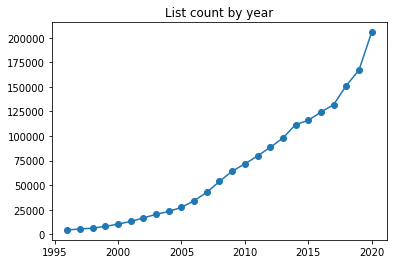

,Year,Count
0,1996,4501
1,1997,5378
2,1998,6296
3,1999,8125
4,2000,10352
5,2001,13144
6,2002,16691
7,2003,20368
8,2004,23253
9,2005,27461


In [71]:
# Make a dataframe of the years and numbers of entries
all_count = df_sunshine.groupby("Calendar Year").size().sort_values().reset_index()
all_count.columns = ["Year", "Count"]
all_count = all_count.astype(int)
all_count

# Plot a line graph that shows the number of entries per year
plt.plot(all_count["Year"], all_count["Count"], marker="o")
plt.title("List count by year")
plt.show()
all_count

### 2.2 Change in Salary Over Time

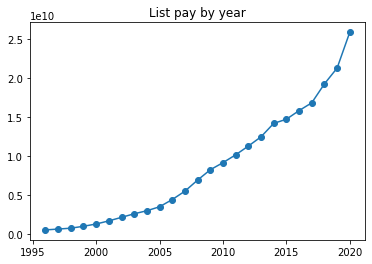

,Year,Pay
0,1996,5.468498e+08
1,1997,6.557922e+08
2,1998,7.689124e+08
3,1999,1.012214e+09
4,2000,1.306782e+09
5,2001,1.704578e+09
6,2002,2.159677e+09
7,2003,2.614003e+09
8,2004,3.005568e+09
9,2005,3.512984e+09


In [72]:
# Make a dataframe of the years and numbers of entries
all_pay = df_sunshine.groupby("Calendar Year").sum().reset_index()
all_pay.columns = ["Year", "Pay"]

# Plot a line graph that shows the number of entries per year
plt.plot(all_pay["Year"], all_pay["Pay"], marker="o")
plt.title("List pay by year")
plt.show()
all_pay

### 2.3 Largest Sector Count

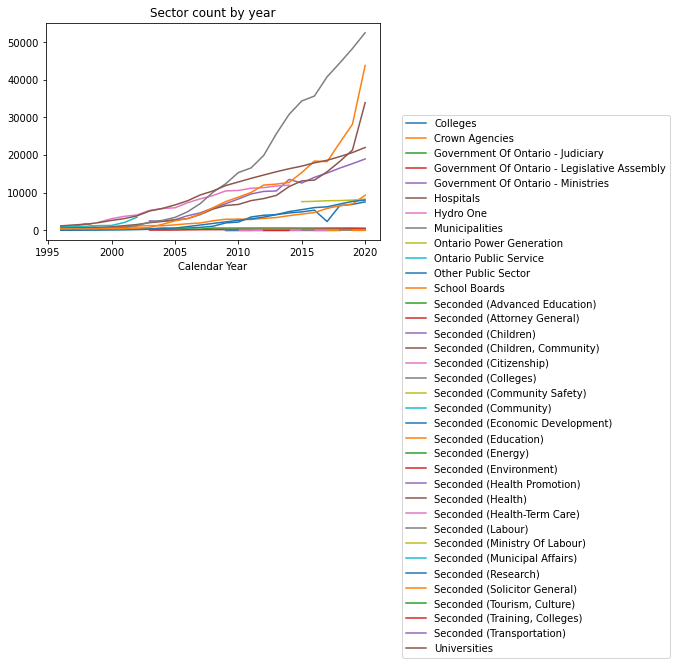

In [58]:
# Make a datframe of the years and sectors
all_sector_count = df_sunshine.groupby(["Calendar Year", "Sector"]).size().unstack()
all_sector_count.plot()
plt.title("Sector count by year")
plt.legend(bbox_to_anchor=(1.05, 0.6))

### 2.4 Largest Sector Budget

Salary Paid                                                   \
Sector             Colleges Crown Agencies Government Of Ontario - Judiciary   
Calendar Year                                                                  
1996           4.582578e+06   7.111010e+07                               NaN   
1997           4.564770e+06   1.285085e+08                               NaN   
1998           5.892958e+06   2.178547e+08                               NaN   
1999           8.819662e+06   7.821683e+07                               NaN   
2000           1.188158e+07   1.109932e+08                               NaN   
2001           1.697995e+07   1.544158e+08                               NaN   
2002           2.521901e+07   1.618111e+08                               NaN   
2003           3.500753e+07   1.757442e+08                      5.267444e+07   
2004           4.848115e+07   1.689107e+08                      6.823861e+07   
2005           5.765022e+07   2.055176e+08                      8.405244e+07   
2006           7.869076e+07   2.539936e+08                      6.316306e+07   
2007           9.761862e+07   2.815802e+08                      6.996576e+07   
2008           1.362619e+08   3.673612e+08                      1.234298e+08   
2009           2.318944e+08   4.056254e+08                      1.083978e+08   
2010           2.565809e+08   4.095464e+08                      1.105516e+08   
2011           3.969844e+08   3.985131e+08                      1.141320e+08   
2012           4.506654e+08   4.363518e+08                      1.176680e+08   
2013           4.728522e+08   4.665549e+08                      1.204564e+08   
2014           5.250545e+08   5.269323e+08                      1.258305e+08   
2015           5.565848e+08   5.827675e+08                      1.226736e+08   
2016           6.123252e+08   6.373661e+08                      1.268999e+08   
2017           2.896335e+08   7.751916e+08                      1.270969e+08   
2018           7.672968e+08   8.642853e+08                      1.334210e+08   
2019           8.090380e+08   9.288541e+08                      1.385232e+08   
2020           9.021030e+08   1.229629e+09                      1.358214e+08   

                                                            \
Sector        Government Of Ontario - Legislative Assembly   
Calendar Year                                                
1996                                                   NaN   
1997                                                   NaN   
1998                                                   NaN   
1999                                                   NaN   
2000                                                   NaN   
2001                                                   NaN   
2002                                                   NaN   
2003                                           10391649.06   
2004                                           10520600.33   
2005                                           11160990.40   
2006                                           18423580.07   
2007                                           24814232.98   
2008                                           28235884.91   
2009                                           29186305.26   
2010                                           30853166.76   
2011                                           30799054.85   
2012                                           32997303.17   
2013                                           31375961.00   
2014                                           33660688.42   
2015                                           32764191.73   
2016                                           36043764.28   
2017                                           44115354.05   
2018                                           46237790.23   
2019                                           53013667.34   
2020                                           56188828.43   

                                      

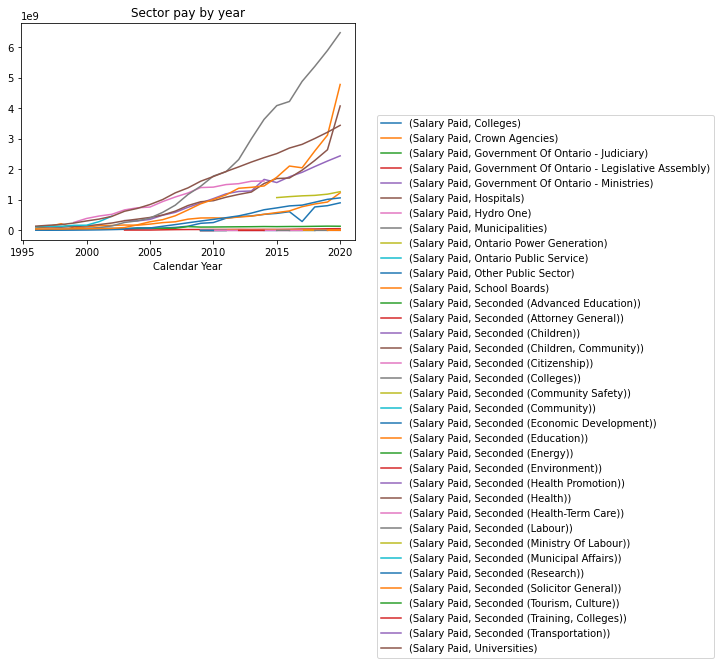

In [70]:
# Make a datframe of the years and sectors
all_sector_pay = df_sunshine.groupby(["Calendar Year", "Sector"]).sum().unstack()
all_sector_pay.plot()
plt.title("Sector pay by year")
plt.legend(bbox_to_anchor=(1.05, 0.6))
all_sector_pay

## Potential Data Science

If we were to take make a machine learning project out of this, we would spend more time cleaning the data. It took alot of effort just to get the dataset to its current state, and could be optimized more to better reflect the data. This data would be very useful placed in a data tool, like an interactive dashboard, that would allow people to explore the data for themselves, and look at some of the data intersections (such as gender *and* race). There are additional questions that need to be explored, such as:
- Are there any sectors that have more equitable proportions of staff in terms of gender and racial identity than other sectors?
- Are there any job titles that are more equitable in their representation?

There are so many additional datasets that could inform this representation, such as the reccomendation to include analysis of recent immigration status or generational status. However, we were unable to determine how to incorporate this data from a regional level of Statistics Canada to the individual level of the sunshine list.

When we were reviewing the datasets, it was easy to imagine all the different ways that we could look at the data, but when we got into the work of cleaning the data and preparing it, addressing all of our questions became a challenge. The volume of the cleaning and the number of questions we were thinking about, we were only able to address a portion of these, and put it into a coherent narrative. This data is so rich, and apparently unexplored from the perspective of newspaper articles that we read, that we see this as an important start to a larger analysis and report.

The process of working in tandem on analyses, aggregating it, and putting it together into a single GitHub required much more coordination than we anticipated. Imagining the work it was easy to think that everyone could work on a section and group it together. However, working on one section often lead to questions that were important for other sections, such as:
- Data cleaning issues
- Which summaries provided a meaningful comparison

## Conclusion

As can be seen in the following graph, the number of provincial employees who earn \\$100,000 or more has increased every year.  From 4,501 people in 1996 and 205,000 people in 2020.  This represents an increase of \\$4,393.916 across the average salaries over the past 24 years.

Table 1: Number of Provincial Employees on the Sunshine List from 1996 to 2020Although the largest increase in people being added to the Sunshine list occured in 2020, this did not correspond to an increase in the average salary.  As can be seen in the following graph, the largest increase in average salary occured from 1999 to 2001 but most recently, in 2020, the average salary decreased.  The difference in average salary from 1996 When considering this decline, it would be worth noting the impact that COVID may have had.

Table 2: Average Salary on the Sunshine List from 1996 to 20201996: 4501
2020:205,000Although the percentage of women in the province has remained fairly stable around 50.6% over the past 25 years, the following graph highlights that women clearly have not had the same representation on the Sunshine list.While the number of both men and women on the list has been increasing over the past 24 years, women continue to be under-represented.

Perhaps more alarming, when considered from the perspective of racial identity, as infered from names, there is greater representation of employees who identify as white than of any other group.  Although there are significant limitations to this approach of infering racial identity, such as when employees may assume westernized names, the contrast highlighted in the following graph invites a new consideration of what the sunshine list is, or should be, shining a light on.